# Feature Engineering

In this notebook we import the `H5` file created in the data `Alternative Energy Data Preparation` notebook and add some temporal factors to use as future parameters in the our models

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pandas_datareader.data as web
from statsmodels.regression.rolling import RollingOLS
from pyfinance import ols

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [4]:
DATA_STORE = 'Data/H5/assets.h5'

We select the close price and unpivot the column to convert the DataFrame to wide format with tickers as the columns and timestamps as the rows:

In [5]:
with pd.HDFStore(DATA_STORE) as store:
    AltEnergy_prices = (store['Alt_Energy/prices']
              .loc[idx[:], 'Close']
              .unstack('Ticker'))

In [6]:
AltEnergy_prices.head()

Ticker,BE,BWEN,CSIQ,DOGEF,ENPH,FSLR,NEE,RUN,SEDG,SIEGY,VWSYF
Date,,,,,,,,,,,
2019-01-07,12.41,1.61,16.799999,58.250946,5.26,45.790001,40.522408,10.56,35.009998,47.956219,74.181648
2019-01-08,12.73,1.60,17.129999,57.650864,5.35,46.230000,40.818771,10.71,35.000000,48.032772,74.181648
2019-01-09,12.14,1.60,17.209999,57.650864,5.63,46.959999,40.642365,11.47,35.459999,48.415531,77.006691
2019-01-10,12.02,1.53,17.620001,59.151073,5.63,47.740002,41.253918,11.51,35.990002,48.636688,75.818230
2019-01-11,12.24,1.73,17.660000,58.979622,5.68,47.500000,41.329189,11.65,36.400002,47.658508,75.233742


## Create daily return series

To account for momentum patterns, the historical returns using the method **.pct_change(n_periods)** is computed. These are returns over various daily periods identified by lags.

The returns are normalized using the geometric average and we obtain compounded daily returns for six periods ranging from 1 day to 1 month:

In [7]:
outlier_cutoff = 0.01
data = pd.DataFrame()
lags = [1, 2, 4, 7, 14, 30]

for lag in lags:
    
    data[f'return_{lag}d'] = (AltEnergy_prices.pct_change(lag).stack()
                           .pipe(lambda x: x.clip(lower = x.quantile(outlier_cutoff),
                                                  upper = x.quantile(1-outlier_cutoff)))
                           .add(1).pow(1/lag).sub(1))
    
data = data.swaplevel().dropna()
data.head()

,,return_1d,return_2d,return_4d,return_7d,return_14d,return_30d
Ticker,Date,,,,,,
BE,2019-02-20,0.110512,0.045389,0.029571,0.029851,0.021235,-0.000135
BWEN,2019-02-20,-0.027586,0.014494,0.003578,0.003077,-0.005817,-0.004412
CSIQ,2019-02-20,-0.033632,0.024291,0.005171,0.006671,0.002224,0.008334
DOGEF,2019-02-20,0.000000,0.000000,-0.003617,-0.002656,0.001153,0.001862
ENPH,2019-02-20,-0.043651,-0.027838,-0.014982,-0.004082,0.000695,0.010660


Below we see a correlation map that shows how correlated each daily return value is to one another. 

2 day and 4 day have the strongest correlative link while, unsurprisingly, 1 day and 30 day have the least

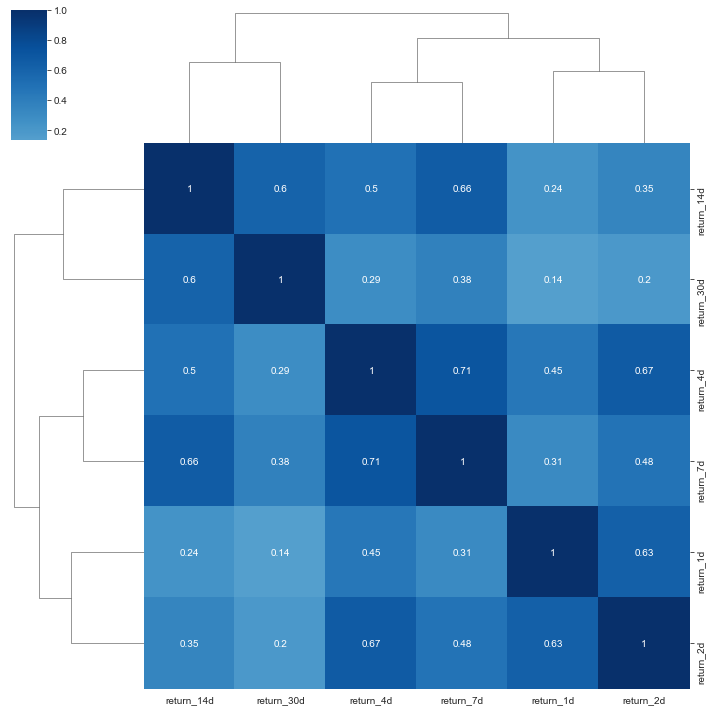

In [8]:
sns.clustermap(data.corr('spearman'), annot=True, center=0, cmap='Blues');

## Momentum factors

We can use these results to compute momentum factors based on the difference between returns over longer periods and the most recent monthly return.

In [9]:
for lag in [1, 2, 4, 7, 14, 30]:
    data[f'momentum_{lag}'] = data[f'return_{lag}d'].sub(data.return_1d)
    
data.head()

,,return_1d,return_2d,return_4d,return_7d,return_14d,return_30d,momentum_1,momentum_2,momentum_4,momentum_7,momentum_14,momentum_30
Ticker,Date,,,,,,,,,,,,
BE,2019-02-20,0.110512,0.045389,0.029571,0.029851,0.021235,-0.000135,0.0,-0.065123,-0.080941,-0.080661,-0.089277,-0.110647
BWEN,2019-02-20,-0.027586,0.014494,0.003578,0.003077,-0.005817,-0.004412,0.0,0.042080,0.031164,0.030663,0.021769,0.023174
CSIQ,2019-02-20,-0.033632,0.024291,0.005171,0.006671,0.002224,0.008334,0.0,0.057923,0.038803,0.040303,0.035857,0.041967
DOGEF,2019-02-20,0.000000,0.000000,-0.003617,-0.002656,0.001153,0.001862,0.0,0.000000,-0.003617,-0.002656,0.001153,0.001862
ENPH,2019-02-20,-0.043651,-0.027838,-0.014982,-0.004082,0.000695,0.010660,0.0,0.015812,0.028669,0.039569,0.044346,0.054311


### Date Indicators

Add day, month, and year columns

In [10]:
dates = data.index.get_level_values('Date')
data['month'] = dates.month
data['year'] = dates.year
data['day'] = dates.dayofweek

## Lagged returns

To use lagged values as input variables or features associated with the current observations, we use the .shift() method to move historical returns up to the current period:

In [11]:
for t in range(1, 7):
    data[f'return_1d_t-{t}'] = data.groupby(level='Ticker').return_1d.shift(t)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5214 entries, ('BE', Timestamp('2019-02-20 00:00:00')) to ('VWSYF', Timestamp('2021-01-05 00:00:00'))
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1d      5214 non-null   float64
 1   return_2d      5214 non-null   float64
 2   return_4d      5214 non-null   float64
 3   return_7d      5214 non-null   float64
 4   return_14d     5214 non-null   float64
 5   return_30d     5214 non-null   float64
 6   momentum_1     5214 non-null   float64
 7   momentum_2     5214 non-null   float64
 8   momentum_4     5214 non-null   float64
 9   momentum_7     5214 non-null   float64
 10  momentum_14    5214 non-null   float64
 11  momentum_30    5214 non-null   float64
 12  month          5214 non-null   int64  
 13  year           5214 non-null   int64  
 14  day            5214 non-null   int64  
 15  return_1d_t-1  5203 non-null   float64
 16  return_1d_t-2  519

## Target: Holding Period Returns

Similarly, to compute returns for various holding periods, we use the normalized period returns computed previously and shift them back to align them with the current financial features

In [12]:
for t in [1, 2, 4, 7, 14, 30]:
    data[f'target_{t}d'] = data.groupby(level='Ticker')[f'return_{t}d'].shift(-t)

In [13]:
cols = ['target_1d',
        'target_2d',
        'target_4d', 
        'return_7d',
        'return_14d',
        'return_30d',
        'return_1d_t-1',
        'return_1d_t-2',
        'return_1d_t-3']

data[cols].dropna().sort_index().head(10)

target_1d  target_2d  target_4d  return_7d  return_14d  \
Ticker Date                                                                 
BE     2019-02-25   0.051502  -0.006459   0.039131   0.034841    0.018875   
       2019-02-26  -0.061224  -0.007854   0.007234   0.033272    0.023014   
       2019-02-27   0.048551   0.086812   0.025460   0.028834    0.022113   
       2019-02-28   0.126468   0.022552  -0.006103   0.038202    0.024224   
       2019-03-01  -0.071779  -0.032428  -0.032535   0.040320    0.034915   
       2019-03-04   0.008592  -0.033954  -0.028095   0.022814    0.034504   
       2019-03-05  -0.074705  -0.032643  -0.016113   0.012181    0.033659   
       2019-03-06   0.011331  -0.022201  -0.004456   0.001425    0.017995   
       2019-03-07  -0.054622   0.000700  -0.018171  -0.004133    0.014397   
       2019-03-08   0.059259   0.013611  -0.018468  -0.003135    0.012723   

                   return_30d  return_1d_t-1  return_1d_t-2  return_1d_t-3  
Ticker Date                                                                 
BE     2019-02-25    0.005048       0.085139       0.045307       0.110512  
       2019-02-26    0.006123      -0.002853       0.085139       0.045307  
       2019-02-27    0.004254       0.051502      -0.002853       0.085139  
       2019-02-28    0.004650      -0.061224       0.051502      -0.002853  
       2019-03-01    0.008037       0.048551      -0.061224       0.051502  
       2019-03-04    0.004788       0.126468       0.048551      -0.061224  
       2019-03-05    0.006219      -0.071779       0.126468       0.048551  
       2019-03-06    0.005382       0.008592      -0.071779       0.126468  
       2019-03-07    0.005815      -0.074705       0.008592      -0.071779  
       2019-03-08    0.005127       0.011331      -0.074705       0.008592

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5214 entries, ('BE', Timestamp('2019-02-20 00:00:00')) to ('VWSYF', Timestamp('2021-01-05 00:00:00'))
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   return_1d      5214 non-null   float64
 1   return_2d      5214 non-null   float64
 2   return_4d      5214 non-null   float64
 3   return_7d      5214 non-null   float64
 4   return_14d     5214 non-null   float64
 5   return_30d     5214 non-null   float64
 6   momentum_1     5214 non-null   float64
 7   momentum_2     5214 non-null   float64
 8   momentum_4     5214 non-null   float64
 9   momentum_7     5214 non-null   float64
 10  momentum_14    5214 non-null   float64
 11  momentum_30    5214 non-null   float64
 12  month          5214 non-null   int64  
 13  year           5214 non-null   int64  
 14  day            5214 non-null   int64  
 15  return_1d_t-1  5203 non-null   float64
 16  return_1d_t-2  519

## Store data

In [15]:
with pd.HDFStore(DATA_STORE) as store:
    store.put('engineered_features', data.sort_index().loc[idx[:, :datetime(2020, 12, 31)], :])
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: Data/H5/assets.h5
/Alt_Energy/prices              frame        (shape->[5544,5]) 
/engineered_features            frame        (shape->[5192,27])
